# Multi-class Dog Breed Classification
Multi-class image classification using Tensorflow 2.0 and Tensorflow Hub

## Data
https://www.kaggle.com/competitions/dog-breed-identification/overview

### TODO:
- Manipulate (crop, resize) or distort them (flip, rotate) to augment and enhance the training dataset. https://www.tensorflow.org/api_docs/python/tf/image
- "How to improve a TensorFlow 2.x image classification model?"
- "TensorFlow 2.x image classification best practices"
- "Transfer learning for image classification with TensorFlow 2.x"
- "Deep learning project examples with TensorFlow 2.x"

In [1]:
%matplotlib inline
import numpy, pandas as pd, os, matplotlib.pyplot as plt, tensorflow as tf, glob
from matplotlib.pyplot import imread
from pathlib import Path
from datetime import date, datetime, timedelta, timezone
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, MaxPooling2D, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetV2L
from sklearn.model_selection import train_test_split
labels_csv = pd.read_csv("data/dog-breed-identification/labels.csv") # the breeds for the images in the train set
print(labels_csv.describe())
print(labels_csv.head());

2025-11-06 18:46:57.410902: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 18:46:57.452238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 18:46:58.296109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


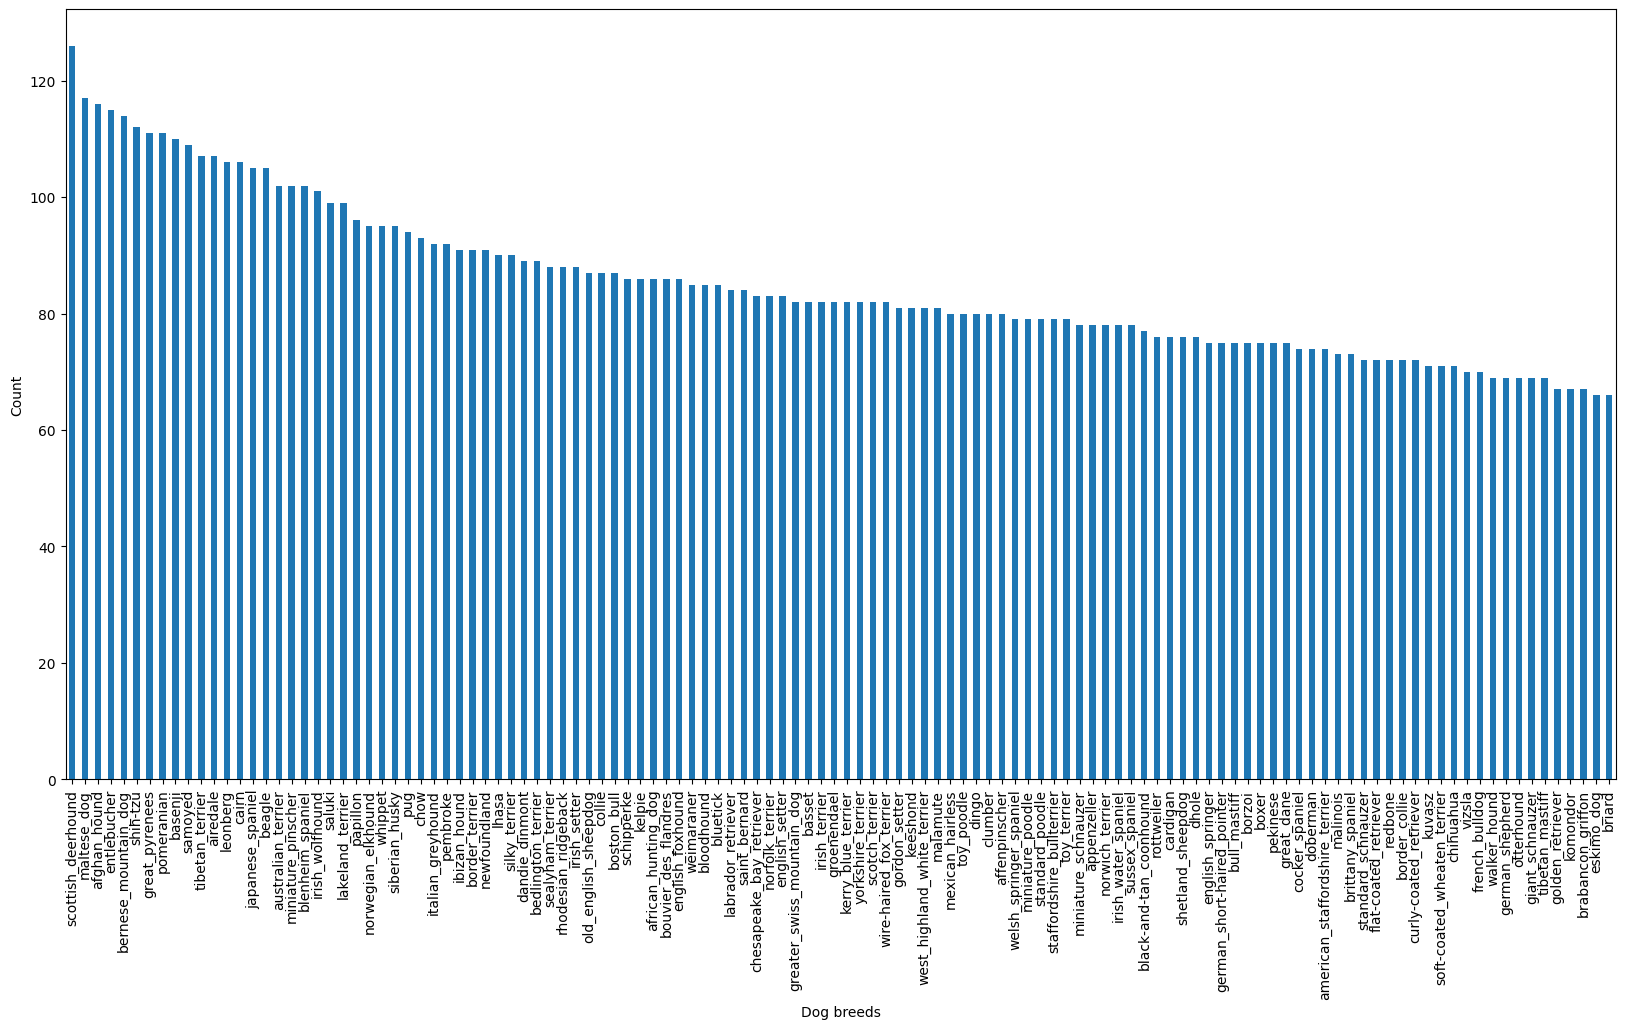

In [2]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10)) # figsize = (width, height)
plt.xlabel("Dog breeds");
plt.ylabel("Count");

In [3]:
train_filenames = [f"data/dog-breed-identification/train/{f}.jpg" for f in labels_csv["id"]]
labels = labels_csv["breed"].to_numpy()
assert len(labels) == len(train_filenames)
assert len(os.listdir("data/dog-breed-identification/train/")) == len(train_filenames)
print(f"train dataset size: {len(labels)}")
train_filenames[:10]
unique_breeds = numpy.unique(labels)
print(f"{len(unique_breeds)} unique breeds")
unique_breeds

train dataset size: 10222
120 unique breeds


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

## Label Encoding
- Turn every label into one-hot encoded boolean array
- This effectively encodes the string labels. The prediction probabilities will follow the order of this encoded array for the probability to label mapping.

In [4]:
bool_labels = [l == unique_breeds for l in labels] # Y
assert len(unique_breeds) == len(bool_labels[0])
bool_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [5]:
# Example: Turn bool array into integer array
print(labels[0]) # original label
index = numpy.where(unique_breeds == labels[0])
print(f"Index of {labels[0]} is {index}: {unique_breeds[index[0][0]]}") # Index of the breed
print(f"{labels[0]} is True at {bool_labels[0].argmax()}")

boston_bull
Index of boston_bull is (array([19]),): boston_bull
boston_bull is True at 19


In [6]:
# Train, validation and test datasets
X = train_filenames
Y = bool_labels
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
# Split the training dataset into training and validation of NUM_IMAGES total size
#X_train, X_validation, Y_train, Y_validation = train_test_split(X[:NUM_IMAGES], Y[:NUM_IMAGES], test_size=0.2)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)
print(f"X_train: {len(X_train)}, Y_train: {len(Y_train)}, X_validation: {len(X_validation)}, Y_validation: {len(Y_validation)}")
# Check out the training data (image file paths and labels)
#X_train[:5], Y_train[:2]
Y_train[:2]
#X_train_tensors = tf.constant(X_train)
#Y_train_tensors = tf.constant(Y_train)
#print(f"X_train_tensors: {X_train_tensors.shape}, Y_train_tensors: {Y_train_tensors.shape}")

X_train: 8177, Y_train: 8177, X_validation: 2045, Y_validation: 2045


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False,  True, Fal

In [7]:
image = imread(train_filenames[42]) # read in an image
image.shape # (M, N, 4) (height, width, RGB+Apha)

(257, 350, 3)

In [8]:
# Process images into tensors
# Use the same image shape as this transfer model https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/140-224-classification
IMAGE_SIZE=224 # Try to use a square image.
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(f"IMG_SHAPE: {IMG_SHAPE}")
BATCH_SIZE=32

def ProcessImage(path: str, size=IMAGE_SIZE) -> tf.Tensor:
    """
    Process input image file content into a tensor.
    """
    img: tf.Tensor = tf.io.read_file(path)
    #print(f"img type: {type(img)}")
    # Turn the JPG image into numerical tensor with 3 colour channels (RGB)
    # https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg
    img = tf.image.decode_jpeg(img, channels=3)
    # Normalize the colour channel values from 0-255 to 0-1
    #img = tf.image.convert_image_dtype(img, tf.float32) # https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype
    # Resize the image
    img = tf.image.resize(img, size=[size, size])
    return img

def get_image_label(path: str, label, size=IMAGE_SIZE):
    """
    Convenience function to pack 2 input parameters into a tuple.
    Return: (Image, label)
    """
    return ProcessImage(path, size), label

IMG_SHAPE: (224, 224, 3)


In [9]:
# Turn data into batches to fit into memory. Recommended batch size is 32.
# Data in the form of tensor tuple (image, label)
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, isValidation=False, isTest=False):
    """
    Creates batches of data out of image (X) and label (Y) pairs.
    Shuffle only if the input is training dataset.
    Accepts test dataset as input without labels.

    Input:
    X: list of file paths
    Y: One-hot encoded boolean labels
    """
    if isTest:
        print("Create test data batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # list
        return data.map(ProcessImage).batch(batch_size)
    elif isValidation:
        print("Create validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y))) # tuples of (path, label)
        return data.map(get_image_label).batch(batch_size)
    else:
        print("Create training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))  # tuples of (path, label)
        # Suffling simple data types especially with fewer dimensions is faster than shuffling the images with 3 dimension.
        return data.shuffle(len(X)).map(get_image_label).batch(batch_size)

In [10]:
train_data = create_data_batches(X_train, Y_train, BATCH_SIZE)
validation_data = create_data_batches(X_validation, Y_validation, BATCH_SIZE, isValidation=True)
# ((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
#  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
# (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
#  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))
train_data.element_spec, validation_data.element_spec

Create training data batches...
Create validation data batches...


I0000 00:00:1762426019.745849  652880 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1970 MB memory:  -> device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [38]:
# Visualize data batches
def ShowDataBatch(images, labels):
    """
    Plot 25 images and their labels in the batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        # Create 5x5 subplots
        ax = plt.subplot(5,5,i+1) # index starts at 1 in the upper-left corner
        img = tf.image.convert_image_dtype(images[i], tf.float32)
        plt.imshow(img)
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

2025-11-06 21:33:35.644874: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node data_augmentation_1/random_translation_1/ReadVariableOp/_12}}]]
	 [[data_augmentation_1/random_rotation_1/Add/_18]] [type.googleapis.com/tensorflow.DerivedStatus='']
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.28509..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [11.517154..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.5522985..254.72263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.069152385..254.95985].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] fo

(np.float32(125.2703), np.float32(3.28509), np.float32(255.0))

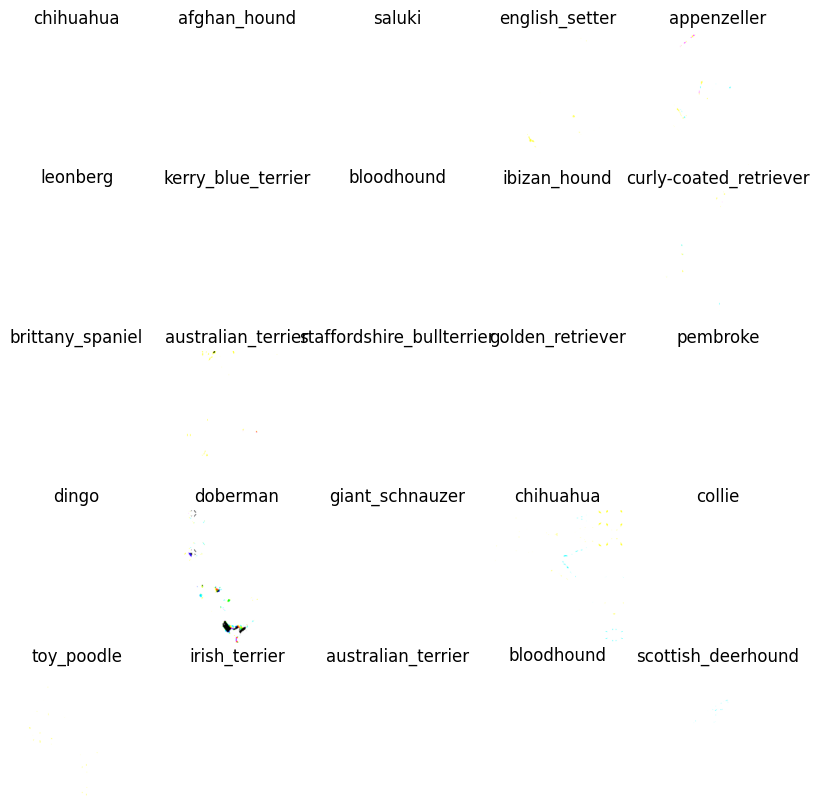

In [39]:
train_images, train_labels = next(train_data.as_numpy_iterator())
assert BATCH_SIZE == len(train_images)
assert BATCH_SIZE == len(train_labels)
ShowDataBatch(train_images, train_labels)
numpy.mean(train_images[0]), numpy.min(train_images[0]), numpy.max(train_images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..244.47476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.5486312..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.33929443..219.81114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2333228..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..249.28003].
Clipping input data to the valid range fo

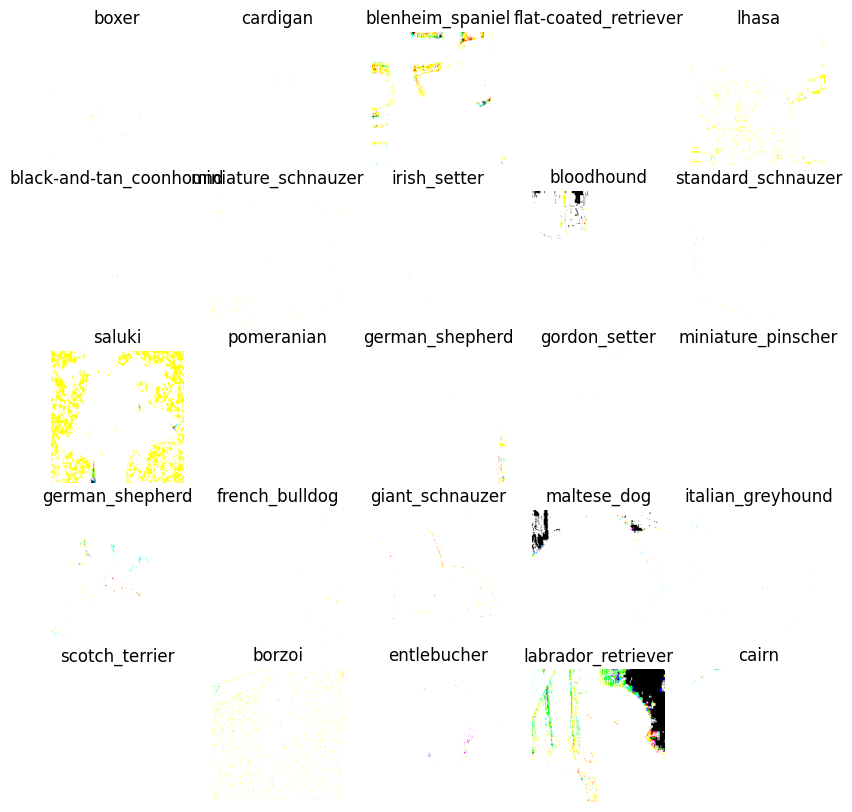

In [13]:
validation_images, validation_labels = next(validation_data.as_numpy_iterator())
assert BATCH_SIZE == len(validation_images)
assert BATCH_SIZE == len(validation_labels)
ShowDataBatch(validation_images, validation_labels)

In [14]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    datagen = ImageDataGenerator(
        rotation_range=40, #
        width_shift_range=0.2, #
        height_shift_range=0.2, #
        shear_range=0.2, # deprecated
        zoom_range=0.2, #
        horizontal_flip=True, #
        fill_mode='nearest' #)
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([
                            RandomFlip('horizontal'),
                            RandomRotation(0.2),
                            RandomTranslation(0.2, 0.2),
                            RandomZoom(0.2, 0.2)
                            ], name = "data_augmentation")
    ### END CODE HERE
    return data_augmentation

In [15]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == (-0.2, 0.2), f"Rotation factor must be 0.2: {augmenter.layers[1].factor}"
#assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


2025-11-06 18:47:01.543011: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.143933..244.013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15870929..251.28249].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.817494..252.7028].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.059472136..242.25537].
Cl

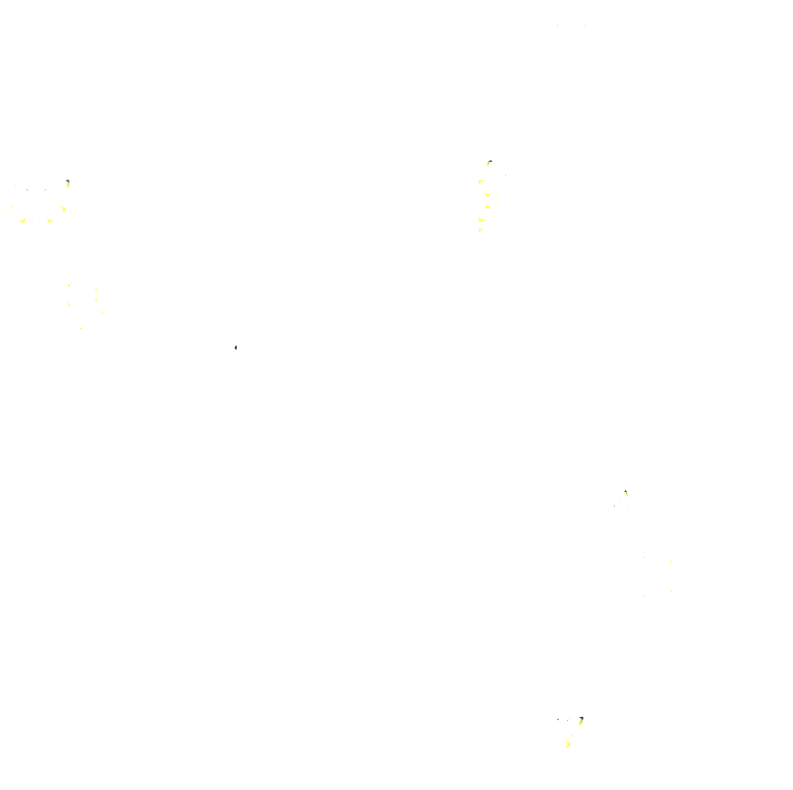

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
"""
https://stackoverflow.com/questions/68449103/tf-keras-preprocessing-image-dataset-from-directory-value-error-no-images-found
train_folder = "data/dog-breed-identification/train"
validation_folder = "data/dog-breed-identification/test"
train_dataset = image_dataset_from_directory(train_folder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(validation_folder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)
"""
train_dataset = train_data.cache().prefetch(buffer_size=AUTOTUNE)

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [17]:
def AugmentData(ds, augment=False):
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (augmenter(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
# Augment the training data set
train_data = AugmentData(train_data, True)

## The Model

In [19]:
# Save model
def SaveModel(model, prefix:str = None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  model_path = f"models/{prefix}-{timestamp}.keras"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

def LoadModel(path: str):
  """
  Loads a saved model from a specified path.
  """
  if path and len(path) and Path(path).exists() and Path(path).is_file():
    print(f"Loading saved model from: {path}...")
    # model = tf.keras.models.load_model(path, custom_objects={"KerasLayer": hub.KerasLayer}) # custom_objects:	Optional dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.
    return tf.keras.models.load_model(path)
  else:
    print(f"Invalid model path! {path}")
  return None

In [20]:
# UNQ_C2
# GRADED FUNCTION
def CreateModel(path: str, retrain: bool, image_shape, output_shape, learning_rate:float = 0.01):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    model = LoadModel(path) if path else None
    if not retrain and model:
        return model
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2L
    # With preprocessing disabled EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [-1, 1] range.
    # convert_image_dtype in ProcessImage() processes the input images to float and have range [0:1]
    base_model = EfficientNetV2L(input_shape=image_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet") # <== Default True expects input to have value [0, 255] but the images have be rescaled with convert_image_dtype in ProcessImage()
    # freeze the base model by making it non trainable
    base_model.trainable = False
    x = base_model.output

    # add the new Multi-class classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D(name="AveragePooling")(x)
    x = BatchNormalization()(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2, name="FinalDropout")(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    #outputs = Dense(output_shape, kernel_regularizer=l2(0.01), name="FinalOutput", activation="softmax")(x) # Decrease kernel_regularizer to fix high bias; Increase to fix high variance. Densely connected, or fully connected
    print(f"output_shape: {output_shape}")
    outputs = Dense(output_shape, activation="softmax", kernel_regularizer=l2(0.01), name="FinalOutput")(x) # Decrease kernel_regularizer to fix high bias; Increase to fix high variance. Densely connected, or fully connected
    
    model = tf.keras.Model(base_model.input, outputs)
    model.name = "DogBreedsClassification"
    model.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    #model.summary()
    return model

In [21]:
def PlotModelPerformance(history):
    acc = [0.] + history.history['accuracy']
    if "val_accuracy" in history.history:
        val_acc = [0.] + history.history['val_accuracy']
    else:
        val_acc = None
    loss = history.history['loss']
    if "val_loss" in history.history:
        val_loss = history.history['val_loss']
    else:
        val_loss = None
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    if val_acc:
        plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

### Create the model

In [22]:
# Load the notebook extension
%load_ext tensorboard
NUM_EPOCHS = 10 #@param {type="slider", min:10, max:100, step=10}
base_learning_rate = 0.001
#model = CreateModel(None, False, IMG_SHAPE, len(unique_breeds), base_learning_rate)
print(f"unique_breeds: {len(unique_breeds)}")
model = CreateModel(f"models/EfficientNetV2L-224-dogbreed-{datetime.now().strftime("%Y-%m-%d-%H%M%S")}.keras", False, IMG_SHAPE, len(unique_breeds), base_learning_rate)
print(f"Number of layers in base_model: {len(model.layers)}")
#model.summary() # output too long

unique_breeds: 120
Invalid model path! models/EfficientNetV2L-224-dogbreed-2025-11-06-184703.keras
output_shape: 120
Number of layers in base_model: 1032


### Train the model
#### Tensorflow Callbacks
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [23]:
def CreateTensorBoardCallback():
    # Create a log directory for storing TensorBoard logs
    logdir = Path(f"logs/dogbreed/{datetime.now().strftime("%Y-%m-%d-%H%M%S")}")
    return TensorBoard(logdir)

def CreateCircuitBreakerCallback(monitor:str="accuracy", patience:int = 3):
    """
    Early-stopping callback which could help prevent overfitting by stopping the training once certain evaluation metrics stop improving / start to plateau.
    """
    return EarlyStopping(monitor=monitor, patience=patience)

### Sanity-check the model.
- Check if the ouput is within the expected range of `[0,1]` and sum to `1.0`

In [24]:
# What does a single batch look like?
image_batch, label_batch = next(iter(train_data))
image_batch.shape, label_batch.shape

# Get a single image with a batch size of 1
single_image_input = tf.expand_dims(image_batch[0], axis=0)
print(f"image: min: {tf.reduce_min(single_image_input)}, max: {tf.reduce_max(single_image_input)}")
# Pass the image through our model
single_image_output_sequential = model(single_image_input)

# Check the output
print(f"output: min: {tf.reduce_min(single_image_output_sequential)}, max: {tf.reduce_max(single_image_output_sequential)}")
print(f"sum: {numpy.sum(single_image_output_sequential)}")
single_image_output_sequential

image: min: 0.7843683958053589, max: 254.0862274169922


2025-11-06 18:47:08.470916: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


output: min: 0.003704746486619115, max: 0.01680198311805725
sum: 1.0


<tf.Tensor: shape=(1, 120), dtype=float32, numpy=
array([[0.00893466, 0.0117035 , 0.00839047, 0.00759279, 0.00716602,
        0.0062227 , 0.00851835, 0.00672626, 0.00777359, 0.00671997,
        0.00820171, 0.00815805, 0.0061698 , 0.00881342, 0.00971675,
        0.00762087, 0.01247283, 0.012432  , 0.0090054 , 0.01248162,
        0.00658155, 0.00580751, 0.00521485, 0.00667373, 0.00783156,
        0.00582965, 0.00567896, 0.00565792, 0.00752965, 0.00596834,
        0.00906203, 0.00801062, 0.00574217, 0.00818855, 0.00370475,
        0.01041517, 0.00618368, 0.00906155, 0.0048086 , 0.00773317,
        0.00910019, 0.0114972 , 0.01680198, 0.00535221, 0.00712121,
        0.01184969, 0.00645287, 0.00917365, 0.00898333, 0.01158299,
        0.00547212, 0.00655855, 0.00815983, 0.00529049, 0.00782352,
        0.00865273, 0.0079056 , 0.00672897, 0.0086709 , 0.00766448,
        0.00488407, 0.01005601, 0.00949797, 0.01159881, 0.00854069,
        0.00671552, 0.00810349, 0.01008089, 0.00693525, 0.00937762

Epoch 1/10


2025-11-06 18:47:34.010595: I external/local_xla/xla/service/service.cc:163] XLA service 0x4b83fcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-06 18:47:34.010634: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A2000 Laptop GPU, Compute Capability 8.6
2025-11-06 18:47:35.761894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-06 18:47:45.803282: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-06 18:47:46.741003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to loc

255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5181 - loss: 4.1526

2025-11-06 18:49:45.365099: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:49:45.479831: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:49:46.388516: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:49:46.509956: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:49:47.455743: E external/local_xla/xla/stream_

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5187 - loss: 4.1483

2025-11-06 18:50:57.085238: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:50:57.205856: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:50:57.326310: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:50:58.308890: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 18:50:58.447858: E external/local_xla/xla/stream_

256/256 ━━━━━━━━━━━━━━━━━━━━ 242s 639ms/step - accuracy: 0.6612 - loss: 3.0421 - val_accuracy: 0.8866 - val_loss: 1.9279
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 314ms/step - accuracy: 0.7439 - loss: 1.8120 - val_accuracy: 0.8924 - val_loss: 1.0738
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 78s 303ms/step - accuracy: 0.7624 - loss: 1.4612 - val_accuracy: 0.8885 - val_loss: 0.8957
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 313ms/step - accuracy: 0.7607 - loss: 1.3623 - val_accuracy: 0.8895 - val_loss: 0.8417
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 79s 307ms/step - accuracy: 0.7707 - loss: 1.2614 - val_accuracy: 0.8885 - val_loss: 0.8122


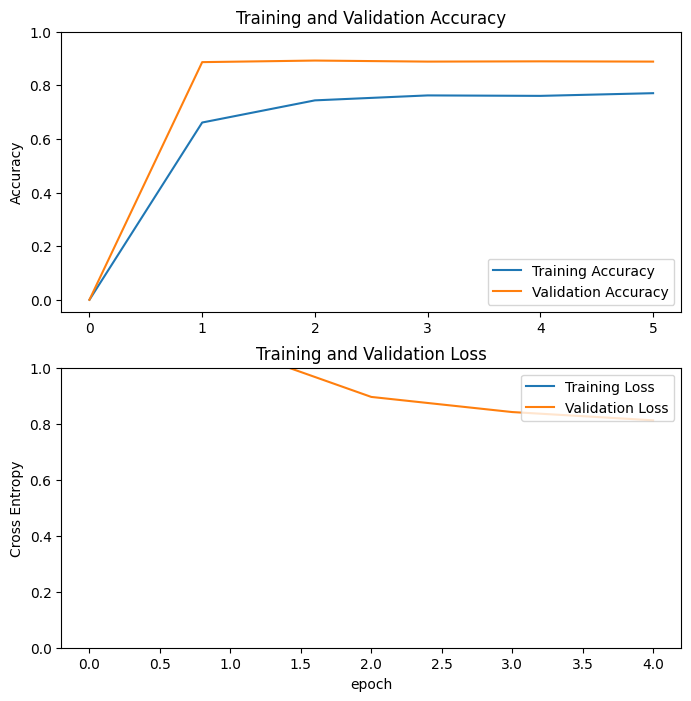

In [25]:
# pipenv run tensorboard --logdir ZTM/logs/dogbreed
tensorboard = CreateTensorBoardCallback()
circuit_breaker = CreateCircuitBreakerCallback("val_accuracy") # This is not orthogonal as it will affect both the bias (training vs bayes optimal error) and variance (Cross-validation vs training error).
history = model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=validation_data, shuffle=True, validation_freq=1, callbacks=[tensorboard, circuit_breaker])
PlotModelPerformance(history)

In [26]:
model.evaluate(validation_data, verbose=1) # verbose shows progress

64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - accuracy: 0.8885 - loss: 0.8122


[0.8121859431266785, 0.8885085582733154]

In [27]:
def GetImageLabel(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """
    assert len(unique_breeds) == len(prediction_probabilities)
    return unique_breeds[numpy.argmax(prediction_probabilities)]

# Extract elements of data from data batch
def ExtractBatch(data):
    """
    Takes a batched dataset of (image, label) tensors and return separate arrays of images and labels
    """
    images = []
    labels = []
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[numpy.argmax(label)])
    return images, labels

def ValidatePrediction(prediction_probabilities, truth, image):
    label = GetImageLabel(prediction_probabilities)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    colour = "green" if label == truth else "red"
    plt.title(f"{label} {numpy.max(prediction_probabilities) * 100 :2.0f}% - {truth}", color = colour)
    return colour == "green"

def ValidateTop10Predictions(prediction_probabilities, truth):
    label = GetImageLabel(prediction_probabilities)
    # Get the top-10 prediction probabilities in descending order.
    top10_indices = prediction_probabilities.argsort()[-10:][::-1]
    top10_probabilities = prediction_probabilities[top10_indices]
    top10_labels = unique_breeds[top10_indices]
    plots = plt.bar(numpy.arange(len(top10_labels)), top10_probabilities, color="grey")
    plt.xticks(numpy.arange(len(top10_labels)), labels=top10_labels, rotation="vertical")
    # Change colors of the true labels
    if numpy.isin(truth, top10_labels):
        plots[numpy.argmax(truth == top10_labels)].set_color("green")
    if label != truth:
        plots[numpy.argmax(top10_labels)].set_color("red")
    


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 527ms/step
predictions: [[9.4999798e-04 2.6769357e-04 2.4193880e-04 ... 7.3249236e-04
  3.8662798e-05 3.0434321e-04]
 [9.4307739e-05 1.2733178e-04 1.4229304e-04 ... 3.6933925e-04
  7.2553885e-05 3.6127221e-05]
 [8.4439496e-05 4.6499004e-05 1.4849784e-04 ... 3.5450834e-05
  7.4997115e-05 3.6948877e-05]
 ...
 [1.2464970e-04 1.5271069e-03 3.4836915e-04 ... 5.6643371e-04
  6.2107663e-03 4.3027940e-05]
 [3.5910186e-04 3.6730565e-04 2.8084105e-04 ... 2.1466071e-04
  2.2586116e-03 7.5016940e-01]
 [1.5722807e-04 6.7213965e-05 1.6632286e-04 ... 4.9050952e-05
  4.2810469e-05 1.2662954e-04]]


2025-11-06 18:57:39.612347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


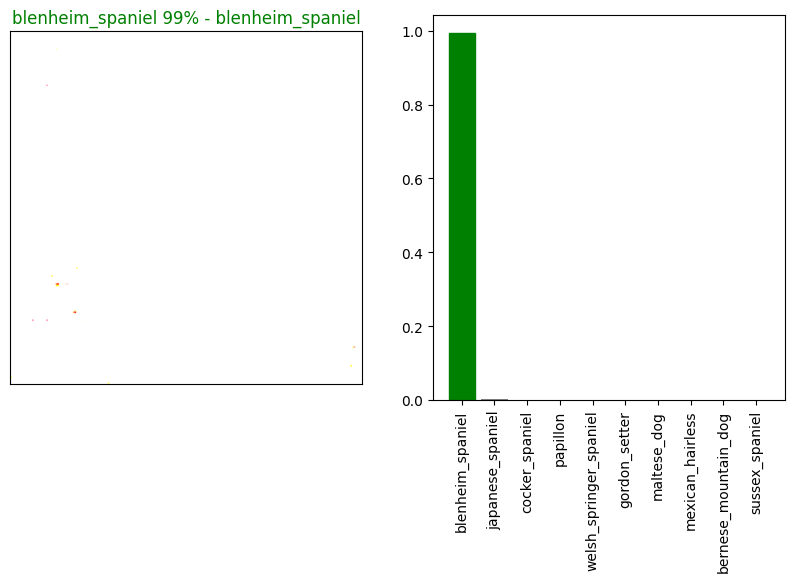

In [28]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(validation_data, verbose=1) # verbose shows us how long there is to go
print(f"predictions: {predictions}")
images, labels = ExtractBatch(validation_data)
index = 100
plt.figure(figsize=(10, 5)) # width, height
plt.subplot(1, 2, 1)
ValidatePrediction(predictions[index], labels[index], images[index])
plt.subplot(1, 2, 2)
ValidateTop10Predictions(predictions[index], labels[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..244.47476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.5486312..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.33929443..219.81114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range fo

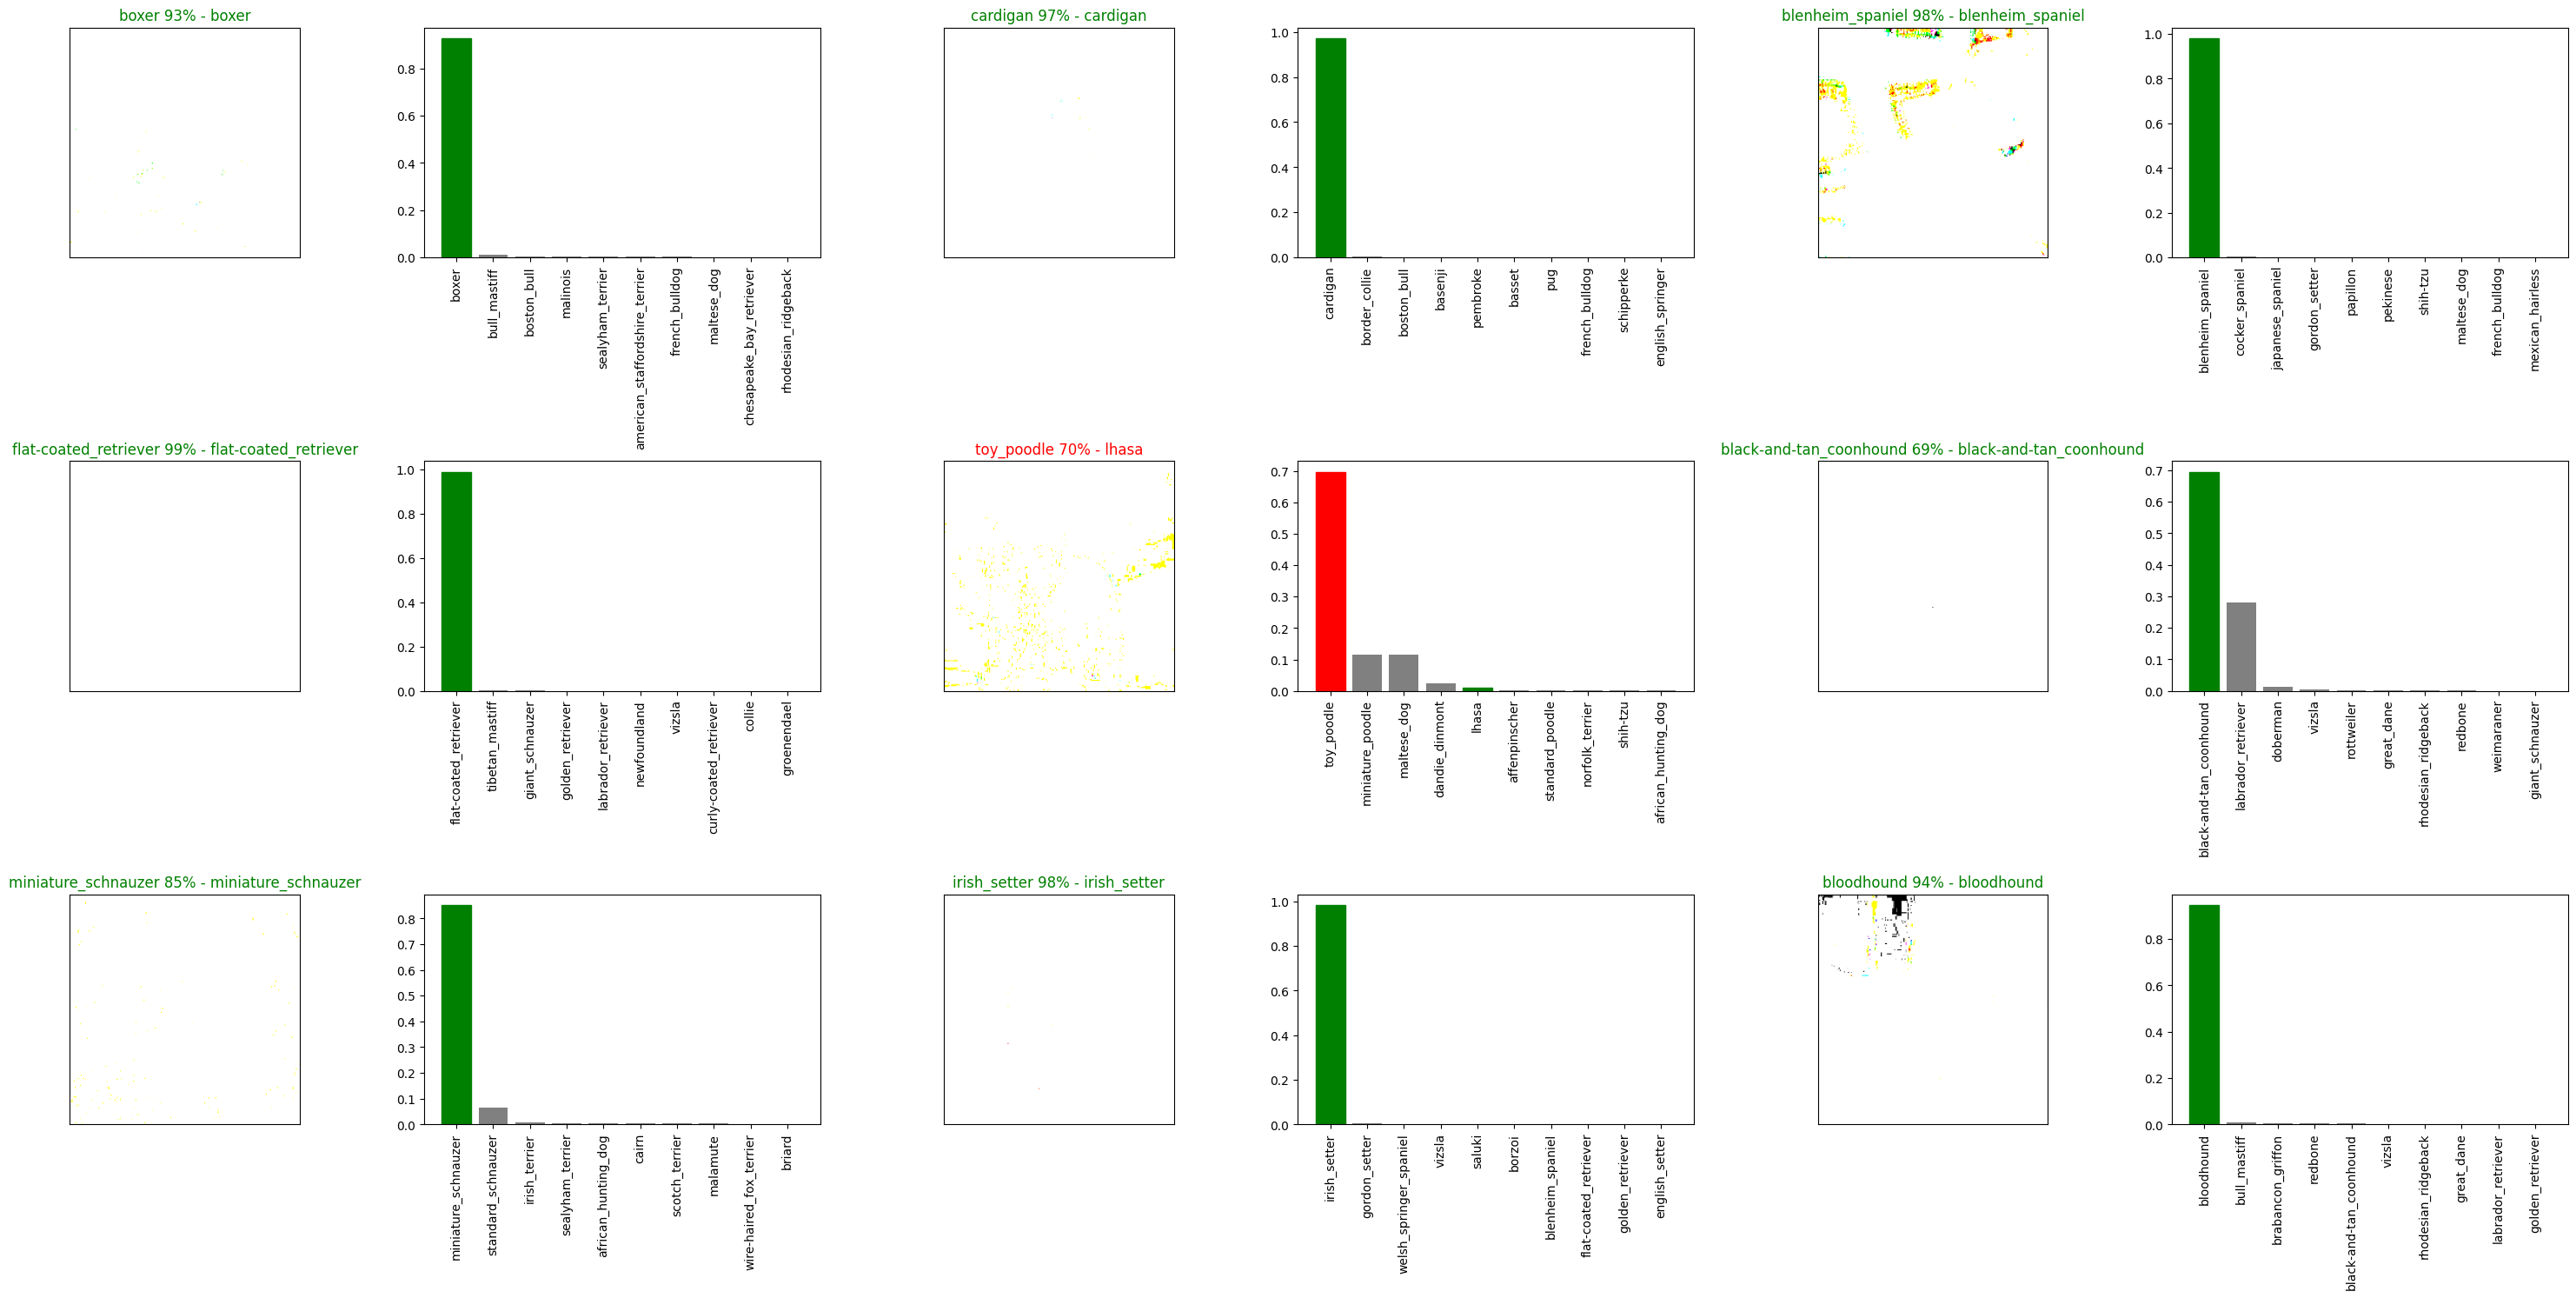

In [29]:
# Let's check a few predictions and their different values
offset = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  ValidatePrediction(predictions[i+offset],
            labels[i+offset],
            images[i+offset],
            )
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  ValidateTop10Predictions(predictions[i+offset], labels[i+offset])
plt.tight_layout(h_pad=1.0)
plt.show()

In [30]:
# Fine-tune the model
#nb_layers = len(model.layers)
#print(f"{nb_layers} layers")

#for i in range(nb_layers): Too long for base model
#    print(f"model {i}: {model.layers[i].name}")

#base_model = model.layers[2] # efficientnetv2-l
model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
# Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.
NUM_LAYERS_TO_TUNE = 30
fine_tune_at = len(model.layers) - NUM_LAYERS_TO_TUNE

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Layers to fine-tune: {[layer.name for layer in model.layers[fine_tune_at:]]}")

model.compile(optimizer=Adam(0.1 * base_learning_rate),
              loss=CategoricalCrossentropy(from_logits=False), # https://github.com/tensorflow/tensorflow/issues/101296 https://github.com/tensorflow/tensorflow/issues/101499
              metrics=['accuracy'])
tensorboard = CreateTensorBoardCallback() # Create a new folder with current timestamp

Number of layers in the base model:  1032
Layers to fine-tune: ['block7f_se_reshape', 'block7f_se_reduce', 'block7f_se_expand', 'block7f_se_excite', 'block7f_project_conv', 'block7f_project_bn', 'block7f_drop', 'block7f_add', 'block7g_expand_conv', 'block7g_expand_bn', 'block7g_expand_activation', 'block7g_dwconv2', 'block7g_bn', 'block7g_activation', 'block7g_se_squeeze', 'block7g_se_reshape', 'block7g_se_reduce', 'block7g_se_expand', 'block7g_se_excite', 'block7g_project_conv', 'block7g_project_bn', 'block7g_drop', 'block7g_add', 'top_conv', 'top_bn', 'top_activation', 'AveragePooling', 'batch_normalization', 'FinalDropout', 'FinalOutput']


# Train on complete dataset

Create training data batches...
Epoch 1/400
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7858 - loss: 1.2068

2025-11-06 19:01:34.938452: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 19:01:35.051660: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 19:01:35.944455: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 19:01:36.063553: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 19:01:36.981506: E external/local_xla/xla/stream_

320/320 ━━━━━━━━━━━━━━━━━━━━ 240s 544ms/step - accuracy: 0.7919 - loss: 1.1649 - val_accuracy: 0.9027 - val_loss: 0.7101
Epoch 2/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 97s 299ms/step - accuracy: 0.7969 - loss: 1.1059 - val_accuracy: 0.9090 - val_loss: 0.6683
Epoch 3/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 98s 302ms/step - accuracy: 0.8051 - loss: 1.0694 - val_accuracy: 0.9086 - val_loss: 0.6366
Epoch 4/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 99s 307ms/step - accuracy: 0.8055 - loss: 1.0392 - val_accuracy: 0.9105 - val_loss: 0.6112
Epoch 5/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 100s 309ms/step - accuracy: 0.8050 - loss: 1.0138 - val_accuracy: 0.9110 - val_loss: 0.5944
Epoch 6/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 98s 304ms/step - accuracy: 0.8047 - loss: 1.0027 - val_accuracy: 0.9154 - val_loss: 0.5751
Epoch 7/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 96s 299ms/step - accuracy: 0.8080 - loss: 0.9750 - val_accuracy: 0.9134 - val_loss: 0.5578
Epoch 8/400
320/320 ━━━━━━━━━━━━━━━━━━━━ 97s 299ms/step - accuracy: 0.8100 - loss: 0.9

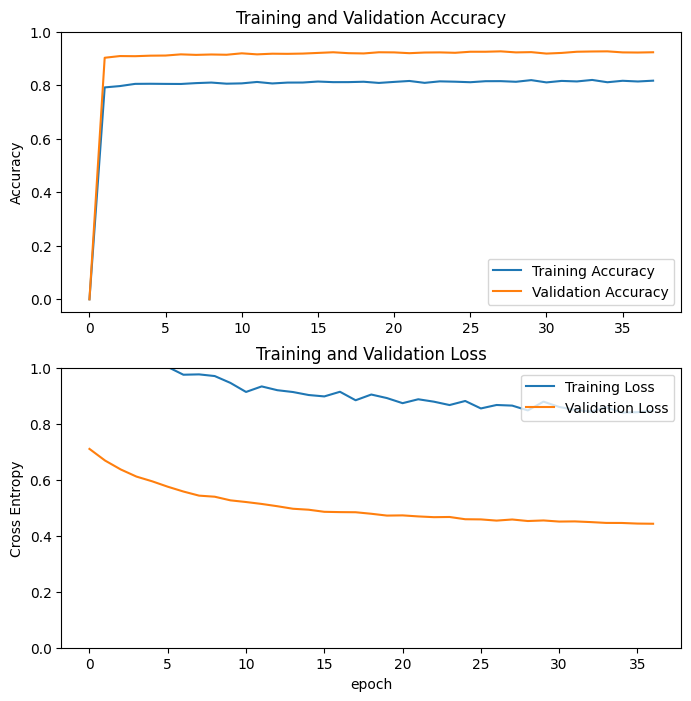

In [ ]:
# Train on complete dataset (augmented)
len(X), len(Y)
train_data = AugmentData(create_data_batches(X, Y, BATCH_SIZE), True)
# With preprocessing disabled EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [-1, 1] range
#print(f"train_data: {tf.math.reduce_mean(train_data)}")
tensorboard = CreateTensorBoardCallback() # This is needed to create a folder with current timestamp
circuit_breaker = CreateCircuitBreakerCallback("val_accuracy", 10) # validation_data is not augmented.
model = LoadModel("models/EfficientNetV2L-224-dogbreed-20251105-193925.keras")
history = model.fit(x=train_data, epochs=400, validation_data=validation_data, validation_freq=1, callbacks=[tensorboard, circuit_breaker])
PlotModelPerformance(history)

In [33]:
#model.summary() # output too long
model.evaluate(validation_data, verbose=1)
SaveModel(model, "EfficientNetV2L-224-dogbreed") # 537M

64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.9232 - loss: 0.4427
Saving model to: models/EfficientNetV2L-224-dogbreed-20251106-212440.keras...


'models/EfficientNetV2L-224-dogbreed-20251106-212440.keras'

## Make predictions on test dataset

In [34]:
# Make predictions on test dataset
#mode = LoadModel("models/EfficientNetV2L-224-dogbreed-20250930-153437.keras")
test_path = "data/dog-breed-identification/test"
test_filenames = [f"{test_path}/{f}" for f in os.listdir(test_path)]
len(test_filenames)
test_filenames[:10]
test_data = create_data_batches(test_filenames, None, BATCH_SIZE, isTest=True)
test_data.element_spec # TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)

predictions = model.predict(test_data, verbose=1) # verbose shows us how long there is to go
numpy.savetxt(f"models/dogbreed_predictions.csv", predictions, delimiter=",")

Create test data batches...
323/324 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step

2025-11-06 21:26:29.829022: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:26:29.946004: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:26:30.062406: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:26:30.179712: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:26:30.300859: E external/local_xla/xla/stream_

324/324 ━━━━━━━━━━━━━━━━━━━━ 119s 323ms/step


In [35]:
# Kaggle submission format
# id,affenpinscher,afghan_hound,..,yorkshire_terrier
# 000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
# id is the test/{id}.jpg
kaggle_data = pd.DataFrame(columns=["id"] + list(unique_breeds))
#kaggle_data.head()
# Extract ids from path
kaggle_data.id = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
kaggle_data[list(unique_breeds)] = predictions
kaggle_data.head()
kaggle_data.to_csv(f"models/kaggle_submission.csv", index=False) # 0.36286

## Custom Image Predictions

In [36]:
# Create prediction function
def Predict(path:str, # input image (preprocessed by Gradio's Image input to be numpy.array)
                         model: tf.keras.Model,  # Trained TensorFlow model for prediction
                         target_size: int):  # Desired size of the image for input to the model
    """
    Loads an image, preprocesses it, makes a prediction using a provided model,
    and returns a dictionary of prediction probabilities per class name.

    Args:
        image: Input image.
        model: Trained TensorFlow model for prediction.
        target_size (int, optional): Desired size of the image for input to the model. Defaults to 224.
        class_names (list, optional): List of class names for plotting. Defaults to None.

    Returns:
        Dict[str: float]: A dictionary of string class names and their respective prediction probability.
    """
    # Load the image (into PIL format)
    image = tf.keras.utils.load_img(
        path=path,
        color_mode="rgb",
        target_size=IMG_SIZE, # (224, 224) or (img_height, img_width)
    )

    # Create resizing layer to resize the image
    resize = tf.keras.layers.Resizing(height=target_size, width=target_size)

    # Turn the image into a tensor and resize it
    image_tensor = resize(tf.keras.utils.img_to_array(image))

    # Add a batch dimension to the target tensor (e.g. (224, 224, 3) -> (1, 224, 224, 3))
    image_tensor = tf.expand_dims(image_tensor, axis=0)
    assert (1, IMAGE_SIZE, IMAGE_SIZE, 3) == image_tensor.shape
    # Make a prediction with the target model
    pred_probs = model.predict(image_tensor)[0]
    return GetImageLabel(pred_probs)

In [37]:
for dog in glob.glob('images/dog-photo-*.jpg'):
    print(f"{dog} predicions: {Predict(dog, model, IMAGE_SIZE)}")

2025-11-06 21:27:07.978409: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:27:08.086477: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:27:08.194271: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:27:08.302779: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-06 21:27:08.412685: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
images/dog-photo-2.jpg predicions: labrador_retriever
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
images/dog-photo-1.jpg predicions: labrador_retriever
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
images/dog-photo-3.jpg predicions: golden_retriever


In [ ]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.20.0-rc0-4-g72fbba3d20f 2.20.0
